# Set-up

In [6]:
import os
import sys
import glob
import datetime
import pandas as pd
import tqdm.auto as tqdm
import pyranges as pr

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Viz params
sns.set_theme(style="white")
sns.set_palette("Set2")

# ignore pandas warning
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# ThickStart = signalValue - Measurement of overall (usually, average) enrichment for the region.
# ThickEnd = -log10(pvalue) - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.
# ItemRGB = -log10(qvalue) - - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.

In [3]:
# Path to blacklist
blacklist_path = "/cellar/users/aklie/data/ref/blacklists/hg38/temp.bed"
blacklist = pr.read_bed(blacklist_path)
blacklist

,Chromosome,Start,End
0,chr1,627846,636161
1,chr1,5849030,5851628
2,chr1,8908553,8911071
3,chr1,9573523,9576054
4,chr1,32042766,32045260
...,...,...,...
905,chrY,11289740,11335335
906,chrY,11491996,11593907
907,chrY,11669957,11672103
908,chrY,11720471,11750529


In [4]:
def filter_peaks(
    peaks: pr.PyRanges,
    blacklist: pr.PyRanges,
    score_col: str = "Score",
) -> pr.PyRanges:
    """Filter peaks based on blacklist regions.

    Performs the following operations:
    1. Remove blacklist regions using PyRanges.overlap(invert=True)
    2. Keep only chr1-22, X, Y
    3. Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value

    Parameters
    ----------
    peaks : pr.PyRanges
        Peaks to filter as a PyRanges object.
    blacklist : pr.PyRanges
        Blacklist regions as a PyRanges object.
    
    Returns
    -------
    pr.PyRanges
        Filtered peaks as a PyRanges object.
    """
    # Remove blacklist regions
    peaks = peaks.overlap(blacklist, invert=True)

    # Keep only chr1-22, X, Y
    peaks = peaks[peaks.Chromosome.str.match("chr[1-9]|chr1[0-9]|chr2[0-2]|chrX|chrY")]

    # Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value
    peaks_df = peaks.df.sort_values(score_col, ascending=False).drop_duplicates(["Chromosome", "Start", "End"])

    # Convert back to pyranges
    peaks = pr.PyRanges(peaks_df)

    return peaks


def naive_overlap(
    peaks1: pr.PyRanges,
    peaks2: pr.PyRanges,
    frac: float = None,
    return_overlap: bool = False
) -> tuple:
    """Calculate the overlap between two peaksets.

    Calculates the overlap between two peaksets and returns 3 statistics: 
    1) the number of peaks in the overlap, defined as a any peak in peaks1 that overlaps with a peak in peaks2
    2) the percent of peaks in peaks1 that overlap with peaks2, defined as the number of peaks in the overlap divided by the number of peaks in peaks1
    3) the fraction of the peaks in peaks1 that overlap with peaks2 that are intersecting. Defined as the length of the intersecting part of the peaks 
       in peaks1 that overlap with peaks2, divided by the length of the peaks in peaks1 that overlap with peaks2

    If frac is specified, only peaks in peaks1 that overlap with peaks2 and have a fraction overlap greater than frac will be considered.
    

    Parameters
    ----------
    peaks1 : pr.PyRanges
        First peakset as a PyRanges object.
    peaks2 : pr.PyRanges
        Second peakset as a PyRanges object.

    Returns
    -------
    tuple
        Tuple of overlap number and overlap percent.
    """

    # Get the number of peaks in each peakset
    num_peaks = len(peaks1)

    overlap = peaks1.overlap(peaks2, how="first")  # Peaks in peaks1 that overlap with peaks2
    intersect = peaks1.intersect(peaks2, how="first")  # Part of peaks in peaks1 that overlap with peaks2
    overlap_lengths = overlap.lengths()  # Lengths of overlapping peaks in peaks1
    intersect_lengths = intersect.lengths()  # Lengths of intersecting peaks in peaks1
    frac_overlap = (intersect_lengths/overlap_lengths).values  # Fraction of overlapping peaks in peaks1 that are intersecting peaks

    # Filter by fraction overlap if applicable
    if frac:
        frac_mask = (frac_overlap >= frac)
        overlap = overlap[frac_mask]
        frac_overlap = frac_overlap[frac_mask]


    # Get the number of peaks in the overlap
    overlap_num = len(overlap)

    # Get the percent overlap
    overlap_percent = overlap_num / num_peaks
    
    # Return
    if return_overlap:
        return overlap_num, overlap_percent, frac_overlap, overlap
    else:
        return overlap_num, overlap_percent, frac_overlap

# Define set of peaks to analyze

In [5]:
# Pick a resolution, peak caller, and set of cell types to analyze
resolution = "timecourse"  # sample, timecourse, condition_within_batch
caller = "cellcommander"  # cellcommander, snapatac2, pycistopic, archr
cell_types = ["SC.beta", "SC.alpha", "SC.EC", "SC.delta"]

In [7]:
# Make the outdirectory
date = datetime.datetime.now().strftime("%Y_%m_%d")
outdir = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Number of peaks

In [11]:
base_dir = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/{resolution}"
if caller == "cellcommander":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "cellcommander/atac/ENCODE_peak_calls/*.narrowPeak"), recursive=True))
elif caller == "snapatac2":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "snapatac2/peak_calls/*.NarrowPeak"), recursive=True))
elif caller == "pycistopic":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "pycistopic/peak_calls/*_peaks.narrowPeak"), recursive=True))
elif caller == "archr":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "archr/PeakCalls/SplitPeaks/*.bed"), recursive=True))
else:
    raise ValueError("Invalid caller")
print(f"Number of peaksets for {resolution} called by {caller}:", len(peak_files))
peak_files[0]

Number of peaksets for timecourse called by cellcommander: 40


'/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.EC.pooled.pval0.05.300K.narrowPeak'

In [12]:
# Filter by cell type
if cell_types:
    peak_files = [peak_file for peak_file in peak_files if any(cell_type in peak_file for cell_type in cell_types)]
print(f"Number of peaksets for {resolution} called by {caller} in {cell_types}:", len(peak_files))

Number of peaksets for timecourse called by cellcommander in ['SC.beta', 'SC.alpha', 'SC.EC', 'SC.delta']: 26


In [26]:
# Loop through and load each peakset as pyranges object
cell_type_peak_dict = {}
pre_filter_peak_num = []
post_filter_peak_num = []

for i, peak_file in enumerate(tqdm.tqdm(peak_files, total=len(peak_files), desc="Loading and filtering peaks")):
    if caller == "cellcommander":
        cell_type = os.path.basename(peak_file).split(".pooled")[0]
    if caller == "pycistopic":
        cell_type = os.path.basename(peak_file).split("_peaks")[0]
    elif caller == "snapatac2":
        cell_type = peak_file.split("/")[-1].split(".NarrowPeak.gz")[0]
    elif caller == "archr":
        cell_type = peak_file.split("/")[-1].split(".bed")[0]
    sample = peak_file.split("/")[9]

    try:
        # Create entry for cell type if it doesn't exist
        print(f"Processing {sample} {cell_type}")
        if cell_type not in cell_type_peak_dict:
            cell_type_peak_dict[cell_type] = {}
        
        # Read in the narrowPeak file as a pyranges object
        print(f"\tReading {peak_file}")
        cell_type_peak_dict[cell_type][sample] = pr.read_bed(peak_file)
        pre_filter_peak_num.append([cell_type, sample, len(cell_type_peak_dict[cell_type][sample])])

        # Filter peaks
        print(f"\tFiltering {peak_file}")
        cell_type_peak_dict[cell_type][sample] = filter_peaks(cell_type_peak_dict[cell_type][sample], blacklist)
        post_filter_peak_num.append([cell_type, sample, len(cell_type_peak_dict[cell_type][sample])])

    except Exception as e:
        print(f"Error processing {sample} {cell_type}: {e}")
        continue

Loading and filtering peaks:   0%|          | 0/26 [00:00<?, ?it/s]

Processing A2_3-cyt SC.EC
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.EC.pooled.pval0.05.300K.narrowPeak
	Filtering /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.EC.pooled.pval0.05.300K.narrowPeak
Processing A2_3-cyt SC.alpha
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.alpha.pooled.pval0.05.300K.narrowPeak
	Filtering /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.alpha.pooled.pval0.05.300K.narrowPeak
Processing A2_3-cyt SC.beta
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.beta.pooled.pval0.05.300K.narrowPeak
	Filtering /cellar/users/

In [27]:
# Create a dataframe of the number of peaks pre and post filtering
pre_filter_num_df = pd.DataFrame(pre_filter_peak_num, columns=["cell_type", resolution, "num_peaks"])
post_filter_peak_num_df = pd.DataFrame(post_filter_peak_num, columns=["cell_type", resolution, "num_peaks"])
pre_filter_num_df["filter"] = "pre"
post_filter_peak_num_df["filter"] = "post"
peak_num_df = pd.concat([pre_filter_num_df, post_filter_peak_num_df])
peak_num_df.head()

,cell_type,timecourse,num_peaks,filter
0,SC.EC,A2_3-cyt,300000,pre
1,SC.alpha,A2_3-cyt,300000,pre
2,SC.beta,A2_3-cyt,300000,pre
3,SC.delta,A2_3-cyt,300000,pre
4,SC.EC,A2_IFNg,300000,pre


In [28]:
# Add sample metadata if applicable
if resolution == "sample":
    sample_metadata = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/11Sep23/cleaned_samples_tracking_11Sep23.tsv", sep="\t")
    sample_metadata["timepoint"] = sample_metadata["sample_description"].str.split("_").str[0]
    sample_metadata["condition"] = sample_metadata["sample_description"].str.split("_").str[1]
    sample_metadata["sample_id"] = sample_metadata["sample_id"].str.lower()

    # Merge in sample metadata
    peak_num_df = peak_num_df.merge(sample_metadata, left_on="sample", right_on="sample_id")

    # Sort by batch, then condition, then timepoint. Respect the order of the batch_order_dict
    peak_num_df = peak_num_df.sort_values(["condition", "timepoint", "sample"])

    # Save out peak num df
    peak_num_df = peak_num_df[["sample", "cell_type", "condition", "timepoint", "num_peaks", "filter"]]

In [29]:
# Save
peak_num_df.to_csv(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/peak_num.tsv", sep="\t", index=False)
peak_num_df.head()

,cell_type,timecourse,num_peaks,filter
0,SC.EC,A2_3-cyt,300000,pre
1,SC.alpha,A2_3-cyt,300000,pre
2,SC.beta,A2_3-cyt,300000,pre
3,SC.delta,A2_3-cyt,300000,pre
4,SC.EC,A2_IFNg,300000,pre


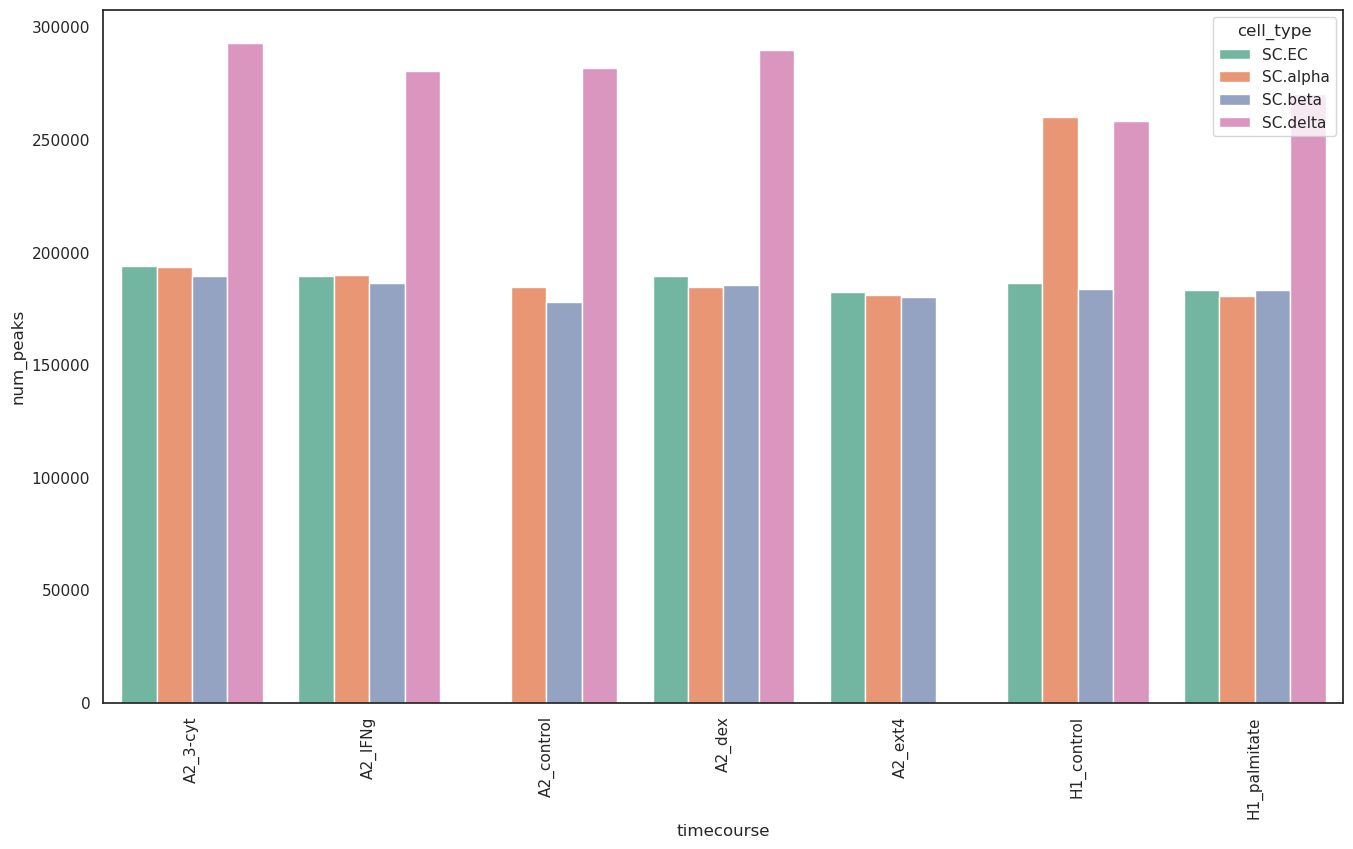

In [30]:
# Post filter
fig, ax = plt.subplots(figsize=(16, 9))

# Create a bar graph with the number of peaks before with all samples in the same cell type the same color
ax = sns.barplot(data=peak_num_df[peak_num_df["filter"] == "post"], x=resolution, y="num_peaks", hue="cell_type", ax=ax)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=90)

# Save
plt.savefig(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/peak_num_post_filter.png", dpi=300, bbox_inches="tight")

# Pairwise overlap in callsets

## For beta cells

In [31]:
# Subset to beta cells
name = "SC.beta" if caller in ["cellcommander", "snapatac2", "archr"] else "SC_beta"
beta_peak_dict = cell_type_peak_dict[name]
beta_peak_dict.keys()

dict_keys(['A2_3-cyt', 'A2_IFNg', 'A2_control', 'A2_dex', 'A2_ext4', 'H1_control', 'H1_palmitate'])

In [32]:
# Loop through and calculate overlap between each pair of samples
overlap_df = pd.DataFrame(columns=["sample1", "sample2", "num_overlapping_peaks", "overlap_pct", "avg_overlap_pct"])
samples = list(beta_peak_dict.keys())
intersect_peaks_dict = {}
intersect_frac_overlap_dict = {}
for i in range(len(beta_peak_dict)):
    for j in range(len(beta_peak_dict)):
        sample1, sample2 = samples[i], samples[j]
        sample1_peaks, sample2_peaks = beta_peak_dict[sample1], beta_peak_dict[sample2]
        overlap_num, overlap_pct, frac_overlap, overlap = naive_overlap(sample1_peaks, sample2_peaks, frac=0.5, return_overlap=True)
        overlap_df = overlap_df.append({"sample1": sample1, "sample2": sample2, "num_overlapping_peaks": overlap_num, "overlap_pct": overlap_pct}, ignore_index=True)
        intersect_peaks_dict[(sample1, sample2)] = overlap
        intersect_frac_overlap_dict[(sample1, sample2)] = frac_overlap

In [33]:
# Grab some dataframes for heatmap visualization
num_overlap_df = overlap_df.pivot(index="sample1", columns="sample2", values="num_overlapping_peaks").astype(int)
pct_overlap_df = overlap_df.pivot(index="sample1", columns="sample2", values="overlap_pct").astype(float)
num_overlap_df.to_csv(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/beta_cell_num_overlap.tsv", sep="\t")
pct_overlap_df.to_csv(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/beta_cell_pct_overlap.tsv", sep="\t")

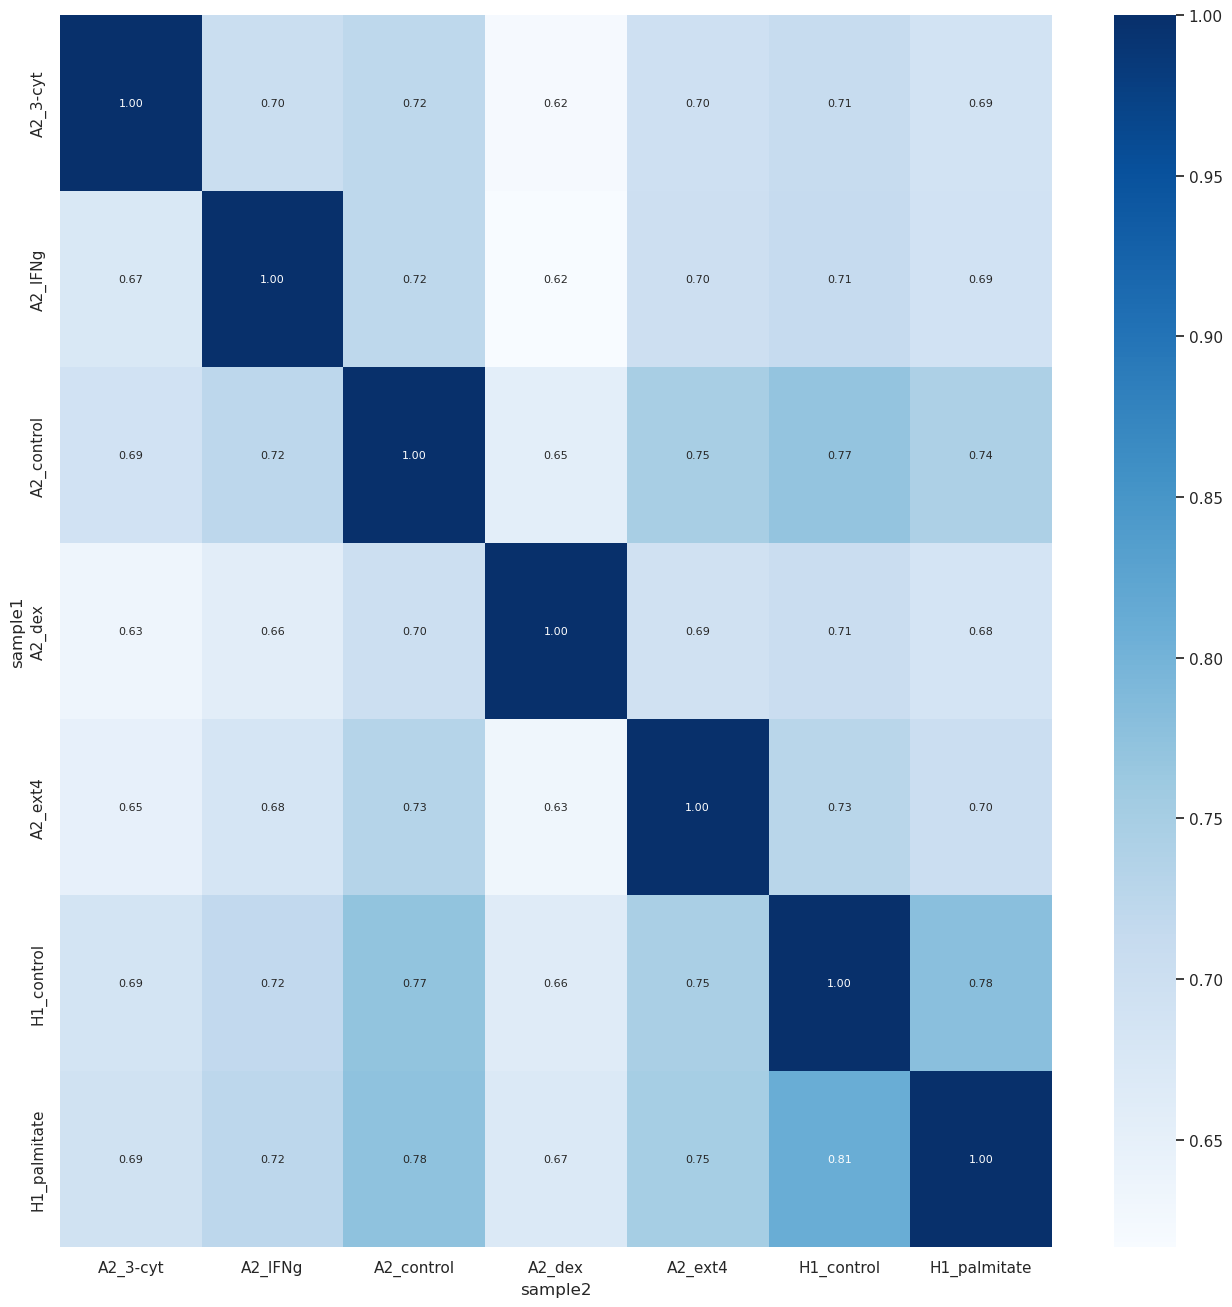

In [34]:
# Heatmap of percent of overlapping peaks, make font size smaller for annot
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(pct_overlap_df, cmap="Blues", annot=True, fmt=".2f", ax=ax, annot_kws={"size": 8})
plt.savefig(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/beta_cell_overlap_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

## For alpha cells

In [35]:
# Subset to alpha cells
name = "SC.alpha" if caller in ["cellcommander", "snapatac2", "archr"] else "SC_alpha"
alpha_peak_dict = cell_type_peak_dict[name]
alpha_peak_dict.keys()

dict_keys(['A2_3-cyt', 'A2_IFNg', 'A2_control', 'A2_dex', 'A2_ext4', 'H1_control', 'H1_palmitate'])

In [36]:
# Loop through and calculate overlap between each pair of samples
overlap_df = pd.DataFrame(columns=["sample1", "sample2", "num_overlapping_peaks", "overlap_pct", "avg_overlap_pct"])
samples = list(alpha_peak_dict.keys())
intersect_peaks_dict = {}
intersect_frac_overlap_dict = {}
for i in range(len(alpha_peak_dict)):
    for j in range(len(alpha_peak_dict)):
        sample1, sample2 = samples[i], samples[j]
        sample1_peaks, sample2_peaks = alpha_peak_dict[sample1], alpha_peak_dict[sample2]
        overlap_num, overlap_pct, frac_overlap, overlap = naive_overlap(sample1_peaks, sample2_peaks, frac=0.5, return_overlap=True)
        overlap_df = overlap_df.append({"sample1": sample1, "sample2": sample2, "num_overlapping_peaks": overlap_num, "overlap_pct": overlap_pct}, ignore_index=True)
        intersect_peaks_dict[(sample1, sample2)] = overlap
        intersect_frac_overlap_dict[(sample1, sample2)] = frac_overlap

In [37]:
# Grab some dataframes for heatmap visualization
num_overlap_df = overlap_df.pivot(index="sample1", columns="sample2", values="num_overlapping_peaks").astype(int)
pct_overlap_df = overlap_df.pivot(index="sample1", columns="sample2", values="overlap_pct").astype(float)
num_overlap_df.to_csv(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/alpha_cell_num_overlap.tsv", sep="\t")
pct_overlap_df.to_csv(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/alpha_cell_pct_overlap.tsv", sep="\t")

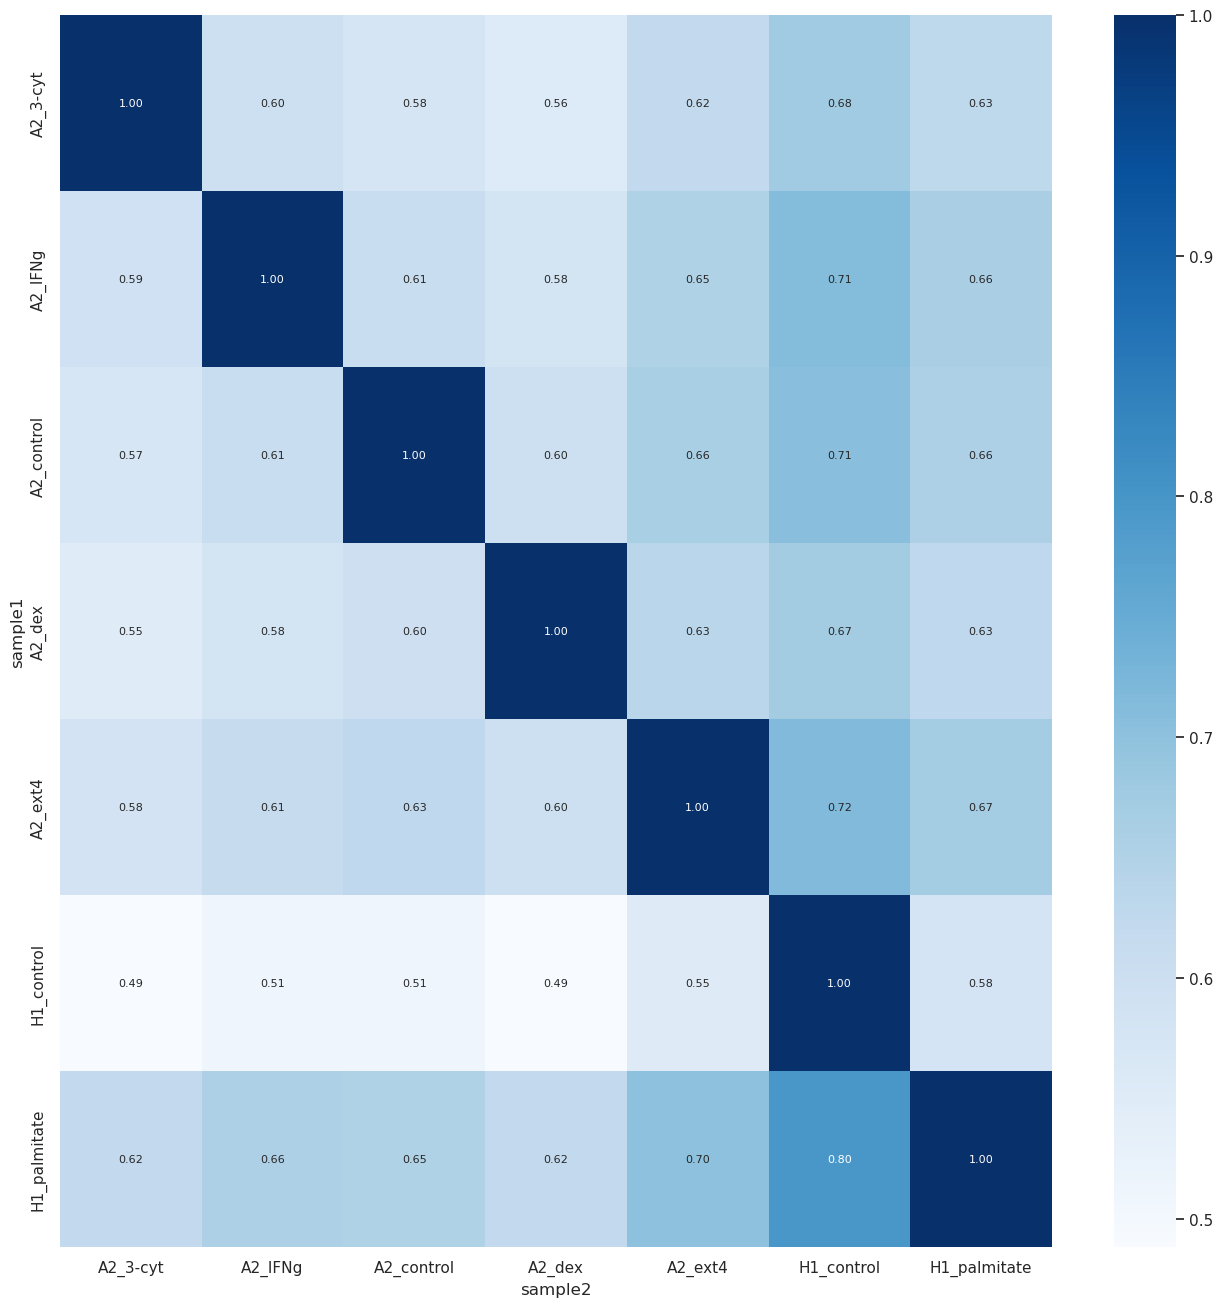

In [38]:
# Heatmap of percent of overlapping peaks, make font size smaller for annot
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(pct_overlap_df, cmap="Blues", annot=True, fmt=".2f", ax=ax, annot_kws={"size": 8})
plt.savefig(f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/{date}/{resolution}/{caller}/peak_analysis/alpha_cell_overlap_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# Peak annotation

In [39]:
base_dir = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/{resolution}"
if caller == "cellcommander":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "cellcommander/atac/ENCODE_peak_calls/*.annotated.bed"), recursive=True))
elif caller == "snapatac2":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "snapatac2/peak_calls/*.annotated.bed"), recursive=True))
elif caller == "pycistopic":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "pycistopic/peak_calls/*.annotated.bed"), recursive=True))
elif caller == "archr":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "archr/PeakCalls/SplitPeaks/*.annotated.bed"), recursive=True))
else:
    raise ValueError("Invalid caller")
print(f"Number of peaksets for {resolution} called by {caller}:", len(peak_files))
peak_files[0]

Number of peaksets for timecourse called by cellcommander: 40


'/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.EC.pooled.pval0.05.300K.annotated.bed'

In [40]:
# Filter by cell type
if cell_types:
    peak_files = [peak_file for peak_file in peak_files if any(cell_type in peak_file for cell_type in cell_types)]
print(f"Number of peaksets for {resolution} called by {caller} in {cell_types}:", len(peak_files))

Number of peaksets for timecourse called by cellcommander in ['SC.beta', 'SC.alpha', 'SC.EC', 'SC.delta']: 26


In [61]:
# Loop through and load each peakset as pyranges object
cell_type_peak_dict = {}
cell_types = []
samples = []
annotation_counts_df = pd.DataFrame(index=["3' UTR", "5' UTR", 'Intergenic', 'TTS', 'exon', 'intron', 'non-coding', 'promoter-TSS'])

for i, peak_file in enumerate(tqdm.tqdm(peak_files, total=len(peak_files), desc="Loading and filtering peaks")):
    if caller == "cellcommander":
        cell_type = os.path.basename(peak_file).split(".pooled")[0]
    elif caller == "pycistopic":
        cell_type = os.path.basename(peak_file).split("_peaks")[0]
    elif caller == "snapatac2":
        cell_type = peak_file.split("/")[-1].split(".annotated.bed")[0]
    elif caller == "archr":
        cell_type = peak_file.split("/")[-1].split(".bed")[0]
    sample = peak_file.split("/")[9]
    cell_types.append(cell_type)
    samples.append(sample)
    
    try:
        # Create entry for cell type if it doesn't exist
        print(f"Processing {sample} {cell_type}")
        if cell_type not in cell_type_peak_dict:
            cell_type_peak_dict[cell_type] = {}
        
        # Read in the bed file as a pandas dataframe
        print(f"\tReading {peak_file}")
        curr_df = pd.read_csv(peak_file, sep="\t")
        cell_type_peak_dict[cell_type][sample] = curr_df

        # If curr_df has no peaks, skip
        if len(curr_df) == 0:
            continue

        # Extract the annotation and count the number of peaks in each annotation
        annotation_counts = curr_df["Annotation"].str.split("(").str[0].str.strip().value_counts().sort_index()
        annotation_counts.name = f"{sample}-{cell_type}"
        annotation_counts_df = annotation_counts_df.merge(annotation_counts, left_index=True, right_index=True)

    except Exception as e:
        print(f"Error processing {sample} {cell_type}: {e}")
        continue

Loading and filtering peaks:   0%|          | 0/26 [00:00<?, ?it/s]

Processing A2_3-cyt SC.EC
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.EC.pooled.pval0.05.300K.annotated.bed
Processing A2_3-cyt SC.alpha
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.alpha.pooled.pval0.05.300K.annotated.bed
Processing A2_3-cyt SC.beta
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.beta.pooled.pval0.05.300K.annotated.bed
Processing A2_3-cyt SC.delta
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.delta.pooled.pval0.05.300K.annotated.bed
Processing A2_IFNg SC.EC
	Reading /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_IFNg/cellcommander/atac/ENCODE_peak_calls/SC

In [62]:
# Normalize columns to percentages
annotation_pcts_df = annotation_counts_df.div(annotation_counts_df.sum(axis=0), axis=1) * 100
annotation_pcts_df.head()

,A2_3-cyt-SC.EC,A2_3-cyt-SC.alpha,A2_3-cyt-SC.beta,A2_3-cyt-SC.delta,A2_IFNg-SC.EC,A2_IFNg-SC.alpha,A2_IFNg-SC.beta,A2_IFNg-SC.delta,A2_control-SC.alpha,A2_control-SC.beta,...,A2_ext4-SC.EC,A2_ext4-SC.alpha,A2_ext4-SC.beta,H1_control-SC.EC,H1_control-SC.beta,H1_control-SC.delta,H1_palmitate-SC.EC,H1_palmitate-SC.alpha,H1_palmitate-SC.beta,H1_palmitate-SC.delta
3' UTR,1.161000,1.202333,1.189000,1.098667,1.179333,1.234333,1.160667,1.172667,1.176333,1.164333,...,1.167667,1.195667,1.151000,1.283000,1.238000,1.220000,1.283333,1.290000,1.245000,1.156333
5' UTR,1.649667,1.721667,1.720667,0.534000,1.700667,1.677333,1.708000,0.853333,1.643000,1.786000,...,1.656000,1.644000,1.694667,1.527000,1.553000,1.222000,1.568667,1.575667,1.591667,1.074000
Intergenic,31.929667,31.913667,32.432333,40.235667,31.865333,31.493333,32.152667,36.922333,32.370333,32.691000,...,32.257000,32.362333,32.369000,32.639667,33.303667,34.288333,32.387333,32.053667,33.150000,35.920333
TTS,1.716667,1.756333,1.690000,1.403000,1.694667,1.779667,1.680667,1.576000,1.747667,1.749667,...,1.687667,1.759333,1.755667,1.808000,1.744667,1.684333,1.813667,1.820333,1.785667,1.615667
exon,3.780667,3.793667,3.692333,2.132333,3.606667,3.836333,3.701333,2.610667,3.795333,3.744333,...,3.616667,3.743333,3.653000,4.000000,3.871000,3.224000,4.011667,3.940333,3.910667,2.883667


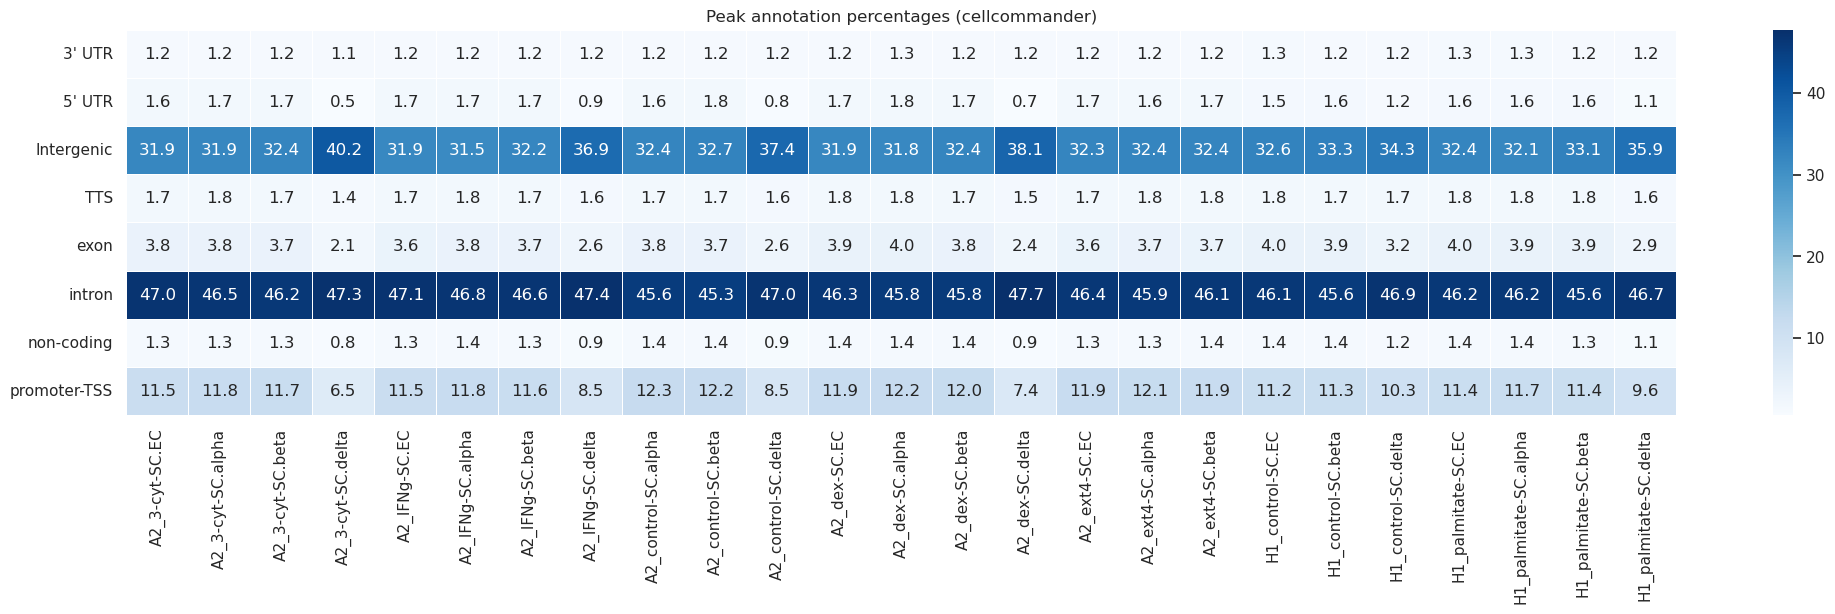

In [64]:
# Plot a heatmap of the annotation percentages
fig, ax = plt.subplots(figsize=(25, 5))
sns.heatmap(annotation_pcts_df, cmap="Blues", annot=True, fmt=".1f", linewidths=.5, ax=ax)
ax.set_title(f"Peak annotation percentages ({caller})")
plt.savefig(os.path.join(outdir, f"peak_annotation_percentages_{caller}.png"), bbox_inches="tight")

# Fraction of reads in peaks (FRiP)

In [65]:
base_dir = f"/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/{resolution}"
if caller == "cellcommander":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "cellcommander/atac/ENCODE_peak_calls/*.frip.qc"), recursive=True))
elif caller == "snapatac2":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "snapatac2/peak_calls/*.frip.txt"), recursive=True))
elif caller == "pycistopic":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "pycistopic/peak_calls/*.frip.txt"), recursive=True))
elif caller == "archr":
    peak_files = sorted(glob.glob(os.path.join(base_dir, "*", "archr/PeakCalls/SplitPeaks/*.frip.txt"), recursive=True))
else:
    raise ValueError("Invalid caller")
print(f"Number of peaksets for {resolution} called by {caller}:", len(peak_files))
peak_files[0]

Number of peaksets for timecourse called by cellcommander: 39


'/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/cellcommander/atac/ENCODE_peak_calls/SC.EC.pooled.pval0.05.300K.bfilt.frip.qc'

In [66]:
# Filter by cell type
if cell_types:
    peak_files = [peak_file for peak_file in peak_files if any(cell_type in peak_file for cell_type in cell_types)]
print(f"Number of peaksets for {resolution} called by {caller} in {cell_types}:", len(peak_files))

Number of peaksets for timecourse called by cellcommander in ['SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'SC.alpha', 'SC.beta', 'SC.delta', 'SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'SC.EC', 'SC.alpha', 'SC.beta', 'SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta']: 25


In [67]:
# Read the first line as an int from each file
cell_types = []
samples = []
frips = []
for i, peak_file in enumerate(tqdm.tqdm(peak_files, total=len(peak_files), desc="Loading and filtering peaks")):
    try:
        cell_type = os.path.basename(peak_file).split(".frip.txt")[0]
        frip = pd.read_csv(peak_file, sep="\t", header=None)[0].values[0]
        sample = peak_file.split("/")[9]
        cell_types.append(cell_type)
        samples.append(sample)
        frips.append(frip)
    except:
        print(f"Error reading {peak_file}")
        pass
df = pd.DataFrame({"cell_type": cell_types, "sample": samples, "frip": frips})
df.head()

Loading and filtering peaks:   0%|          | 0/25 [00:00<?, ?it/s]

,cell_type,sample,frip
0,SC.EC.pooled.pval0.05.300K.bfilt.frip.qc,A2_3-cyt,0.473479
1,SC.alpha.pooled.pval0.05.300K.bfilt.frip.qc,A2_3-cyt,0.491126
2,SC.beta.pooled.pval0.05.300K.bfilt.frip.qc,A2_3-cyt,0.470417
3,SC.delta.pooled.pval0.05.300K.bfilt.frip.qc,A2_3-cyt,0.754623
4,SC.EC.pooled.pval0.05.300K.bfilt.frip.qc,A2_IFNg,0.490459


In [68]:
# Pivot the dataframe
plot_df = df.pivot(index="cell_type", columns="sample", values="frip")
plot_df.to_csv(os.path.join(outdir, "frip.csv"))

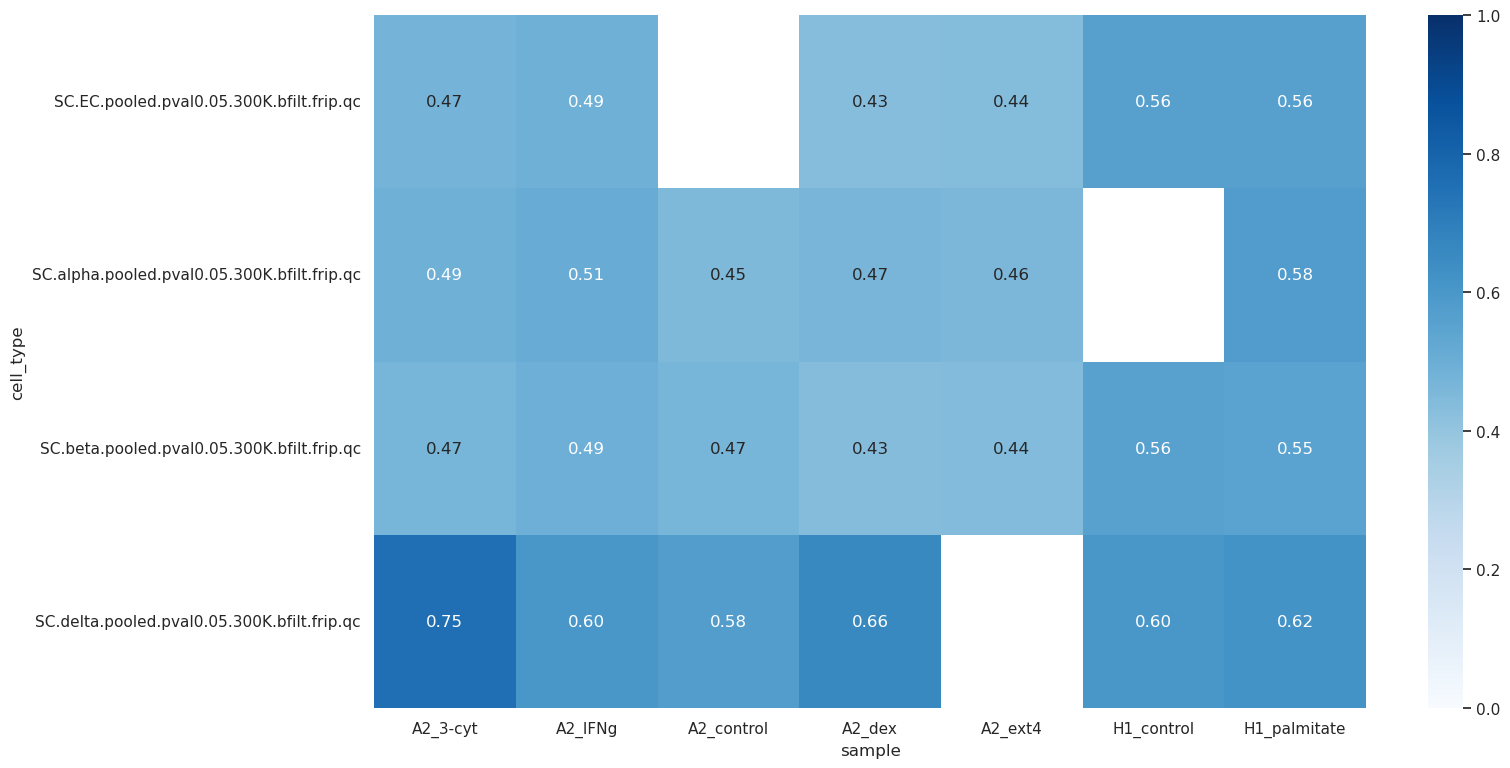

In [70]:
# Plot a heatmap of the annotation percentages
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(plot_df, cmap="Blues", ax=ax, vmin=0, vmax=1, annot=True, fmt=".2f")
plt.savefig(os.path.join(outdir, "frip.png"), bbox_inches="tight")

# DONE!

---